<a href="https://colab.research.google.com/github/sholtodouglas/learning_from_play/blob/master/experimental/Generate_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# TODO: Images in the latent space plot, and then images on test (need to supply them as goals)


In [21]:
import argparse


parser = argparse.ArgumentParser(description='LFP training arguments')
parser.add_argument('run_name')
parser.add_argument('--train_datasets', nargs='+', help='Training dataset names')
parser.add_argument('--test_datasets', nargs='+', help='Testing dataset names')
parser.add_argument('--bulk_datasets', nargs='+', help='data diversity dataset names')
parser.add_argument('--video_datasets', nargs='+', help='for contrastive learning')
parser.add_argument('-c', '--colab', default=False, action='store_true', help='Enable if using colab environment')
parser.add_argument('-s', '--data_source', default='DRIVE', help='Source of training data')
parser.add_argument('-tfr', '--from_tfrecords', default=False, action='store_true', help='Enable if using tfrecords format')
parser.add_argument('-d', '--device', default='TPU', help='Hardware device to train on')
parser.add_argument('-b', '--batch_size', default=512, type=int)
parser.add_argument('-wmax', '--window_size_max', default=50, type=int)
parser.add_argument('-wmin', '--window_size_min', default=20, type=int)
parser.add_argument('-la', '--actor_layer_size', default=2048, type=int, help='Layer size of actor, increases size of neural net')
parser.add_argument('-le', '--encoder_layer_size', default=512, type=int, help='Layer size of encoder, increases size of neural net')
parser.add_argument('-lp', '--planner_layer_size', default=2048, type=int, help='Layer size of planner, increases size of neural net')
parser.add_argument('-lg', '--goal_mapper_layer_size', default=512, type=int, help='Layer size of goal mapping networks from im and sent to goal space, increases size of neural net')
parser.add_argument('-embd', '--img_embedding_size', default=64, type=int, help='Embedding size of features,goal space')
parser.add_argument('-s_embd', '--sentence_embedding_size', default=512, type=int, help='Embedding size of MUSE sentence embeddings')
parser.add_argument('-g_embd', '--gripper_img_embedding_size', default=32, type=int, help='Embedding size of features,goal space')
parser.add_argument('-z', '--latent_dim', default=256, type=int, help='Size of the VAE latent space')
parser.add_argument('-zg', '--goal_space_dim', default=32, type=int, help='Size of the goal embedding space')
parser.add_argument('-g', '--gcbc', default=False, action='store_true', help='Enables GCBC, a simpler model with no encoder/planner')
parser.add_argument('-n', '--num_distribs', default=None, type=int, help='Number of distributions to use in logistic mixture model')
parser.add_argument('-q', '--qbits', default=None, type=int, help='Number of quantisation bits to discrete distributions into. Total quantisations = 2**qbits')
parser.add_argument('-lr', '--learning_rate', type=float, default=3e-4)
parser.add_argument('-t', '--train_steps', type=int, default=200000)
parser.add_argument('-r', '--resume', default=False, action='store_true')
parser.add_argument('-B', '--beta', type=float, default=0.00003)
parser.add_argument('-i', '--images', default=False, action='store_true')
parser.add_argument('-i2', '--images2', default=False, action='store_true')
parser.add_argument('-gi', '--gripper_images', default=False, action='store_true')
parser.add_argument('-cnn', '--cnn_type', type=str, default="spatial_softmax")
parser.add_argument('-sim', '--sim', default='Unity', help='Unity/Pybullet')
parser.add_argument('-vq', '--discrete', default=False, action='store_true')
parser.add_argument('-tmp', '--temperature', type=float, default=0.1)
parser.add_argument('--vq_tiles', type=int, default=5) # split into 5 tiles, must cleanly divide into max_seq_len
parser.add_argument('-nm', '--normalize', default=False, action='store_true')
parser.add_argument('-lang', '--use_language', default=False, action='store_true')
parser.add_argument('-cont', '--use_contrastive', default=False, action='store_true')
parser.add_argument('-enc_all', '--encode_all', default=False, action='store_true', help='encode_actions_and_proprio not just imgs')
parser.add_argument('-sub', '--sub_out_language_percent',  type=float, default=0.25)
parser.add_argument('--fp16', default=False, action='store_true')
parser.add_argument('--bucket_name', help='GCS bucket name to stream data from')
parser.add_argument('--tpu_name', help='GCP TPU name') # Only used in the script on GCP
# Set these to split the dataset up so we control the proportion of lang vs bulk vs video etc - make them batch numbers 
parser.add_argument('-ss', '--standard_split', type=int, default=0)
parser.add_argument('-bs', '--bulk_split', type=int, default=0)
parser.add_argument('-ls', '--lang_split', type=int, default=0)
parser.add_argument('-vs', '--video_split', type=int, default=0)

# args = parser.parse_args('''
# PROB0_02
# --train_dataset UR5 UR5_slow_gripper UR5_high_transition
# --test_dataset UR5_slow_gripper_test
# -c
# -d GPU
# -b 512
# -la 2048
# -le 512
# -lp 512
# -z 256
# -lr 3e-4
# -n 5


# '''.split())

# args = parser.parse_args('''
# IMB0_00003
# --train_dataset UR5 UR5_slow_gripper UR5_high_transition
# --test_dataset UR5_slow_gripper_test
# -c
# -d GPU
# -b 512
# -la 2048
# -le 512
# -lp 512
# -z 256
# -lr 3e-4
# -i
# -tfr
# -wmin 10
# -wmax 40


# '''.split())


args = parser.parse_args('''
PROB_B0_02
--train_dataset pybullet/UR5, pybullet/UR5_high_transition, pybullet/UR5_slow_gripper
--test_dataset pybullet/UR5_slow_gripper_test
-c
-d GPU
-b 2
-la 2048
-le 512
-lp 512
-z 256
-lr 3e-4
-tfr
-wmin 20
-wmax 40
-n 5
-sim Pybullet
--encode_all
'''.split())


# args = parser.parse_args('''
# GCSB0_0003
# --train_dataset UR5 UR5_slow_gripper UR5_high_transition
# --test_dataset UR5_slow_gripper_test
# -c
# -d GPU
# -b 512
# -la 2048
# -le 512
# -lp 512
# -z 256
# -lr 3e-4



# '''.split())

path = f"saved_models/{args.run_name}"    

In [26]:
import argparse


parser = argparse.ArgumentParser(description='LFP training arguments')
parser.add_argument('run_name')
parser.add_argument('--train_datasets', nargs='+', help='Training dataset names')
parser.add_argument('--test_datasets', nargs='+', help='Testing dataset names')
parser.add_argument('--bulk_datasets', nargs='+', help='data diversity dataset names')
parser.add_argument('--video_datasets', nargs='+', help='for contrastive learning')
parser.add_argument('-c', '--colab', default=False, action='store_true', help='Enable if using colab environment')
parser.add_argument('-s', '--data_source', default='DRIVE', help='Source of training data')
parser.add_argument('-tfr', '--from_tfrecords', default=False, action='store_true', help='Enable if using tfrecords format')
parser.add_argument('-d', '--device', default='TPU', help='Hardware device to train on')
parser.add_argument('-b', '--batch_size', default=512, type=int)
parser.add_argument('-wmax', '--window_size_max', default=50, type=int)
parser.add_argument('-wmin', '--window_size_min', default=20, type=int)
parser.add_argument('-la', '--actor_layer_size', default=2048, type=int, help='Layer size of actor, increases size of neural net')
parser.add_argument('-le', '--encoder_layer_size', default=512, type=int, help='Layer size of encoder, increases size of neural net')
parser.add_argument('-lp', '--planner_layer_size', default=2048, type=int, help='Layer size of planner, increases size of neural net')
parser.add_argument('-lg', '--goal_mapper_layer_size', default=512, type=int, help='Layer size of goal mapping networks from im and sent to goal space, increases size of neural net')
parser.add_argument('-embd', '--img_embedding_size', default=64, type=int, help='Embedding size of features,goal space')
parser.add_argument('-s_embd', '--sentence_embedding_size', default=512, type=int, help='Embedding size of MUSE sentence embeddings')
parser.add_argument('-g_embd', '--gripper_img_embedding_size', default=32, type=int, help='Embedding size of features,goal space')
parser.add_argument('-z', '--latent_dim', default=256, type=int, help='Size of the VAE latent space')
parser.add_argument('-zg', '--goal_space_dim', default=32, type=int, help='Size of the goal embedding space')
parser.add_argument('-g', '--gcbc', default=False, action='store_true', help='Enables GCBC, a simpler model with no encoder/planner')
parser.add_argument('-n', '--num_distribs', default=None, type=int, help='Number of distributions to use in logistic mixture model')
parser.add_argument('-q', '--qbits', default=None, type=int, help='Number of quantisation bits to discrete distributions into. Total quantisations = 2**qbits')
parser.add_argument('-lr', '--learning_rate', type=float, default=3e-4)
parser.add_argument('-t', '--train_steps', type=int, default=200000)
parser.add_argument('-r', '--resume', default=False, action='store_true')
parser.add_argument('-B', '--beta', type=float, default=0.00003)
parser.add_argument('-i', '--images', default=False, action='store_true')
parser.add_argument('-i2', '--images2', default=False, action='store_true')
parser.add_argument('-gi', '--gripper_images', default=False, action='store_true')
parser.add_argument('-cnn', '--cnn_type', type=str, default="spatial_softmax")
parser.add_argument('-sim', '--sim', default='Unity', help='Unity/Pybullet')
parser.add_argument('-vq', '--discrete', default=False, action='store_true')
parser.add_argument('-tmp', '--temperature', type=float, default=0.1)
parser.add_argument('--vq_tiles', type=int, default=5) # split into 5 tiles, must cleanly divide into max_seq_len
parser.add_argument('-nm', '--normalize', default=False, action='store_true')
parser.add_argument('-lang', '--use_language', default=False, action='store_true')
parser.add_argument('-cont', '--use_contrastive', default=False, action='store_true')
parser.add_argument('-enc_all', '--encode_all', default=False, action='store_true', help='encode_actions_and_proprio not just imgs')
parser.add_argument('-sub', '--sub_out_language_percent',  type=float, default=0.25)
parser.add_argument('--fp16', default=False, action='store_true')
parser.add_argument('--bucket_name', help='GCS bucket name to stream data from')
parser.add_argument('--tpu_name', help='GCP TPU name') # Only used in the script on GCP
# Set these to split the dataset up so we control the proportion of lang vs bulk vs video etc - make them batch numbers 
parser.add_argument('-ss', '--standard_split', type=int, default=0)
parser.add_argument('-bs', '--bulk_split', type=int, default=0)
parser.add_argument('-ls', '--lang_split', type=int, default=0)
parser.add_argument('-vs', '--video_split', type=int, default=0)

# args = parser.parse_args('''
# PROB0_02
# --train_dataset UR5 UR5_slow_gripper UR5_high_transition
# --test_dataset UR5_slow_gripper_test
# -c
# -d GPU
# -b 512
# -la 2048
# -le 512
# -lp 512
# -z 256
# -lr 3e-4
# -n 5


# '''.split())

# args = parser.parse_args('''
# IMB0_00003
# --train_dataset UR5 UR5_slow_gripper UR5_high_transition
# --test_dataset UR5_slow_gripper_test
# -c
# -d GPU
# -b 512
# -la 2048
# -le 512
# -lp 512
# -z 256
# -lr 3e-4
# -i
# -tfr
# -wmin 10
# -wmax 40


# '''.split())


args = parser.parse_args('''
PROB_B0_02
--train_dataset pybullet/UR5, pybullet/UR5_high_transition, pybullet/UR5_slow_gripper
--test_dataset pybullet/UR5_slow_gripper_test
-c
-d GPU
-b 2
-la 2048
-le 512
-lp 512
-z 256
-lr 3e-4
-tfr
-wmin 20
-wmax 40
-n 5
-i
-sim Pybullet
--encode_all
'''.split())


# args = parser.parse_args('''
# GCSB0_0003
# --train_dataset UR5 UR5_slow_gripper UR5_high_transition
# --test_dataset UR5_slow_gripper_test
# -c
# -d GPU
# -b 512
# -la 2048
# -le 512
# -lp 512
# -z 256
# -lr 3e-4



# '''.split())

path = f"saved_models/{args.run_name}"    

In [41]:
from importlib import reload
reload(lfp)
reload(lfp.data)

<module 'lfp.data' from 'C:\\Users\\Sholto Douglas\\Desktop\\robotics\\learning_from_play\\lfp\\data.py'>

In [123]:

GLOBAL_BATCH_SIZE = 1
dl = lfp.data.PlayDataloader(normalize=args.normalize, include_imgs = args.images, include_imgs2 = args.images2, include_gripper_imgs = args.gripper_images, sim=args.sim, batch_size=GLOBAL_BATCH_SIZE,  window_size=args.window_size_max, min_window_size=args.window_size_min, shuffle_size=1000)

In [124]:
valid_data = dl.extract(TEST_DATA_PATHS, from_tfrecords=args.from_tfrecords)
valid_dataset = dl.load(valid_data)
v_it = iter(valid_dataset)


{   'acts': TensorSpec(shape=(1, None, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(1, None), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(1, None, 11), dtype=tf.float32, name=None),
    'imgs': TensorSpec(shape=(1, None, 200, 200, 3), dtype=tf.uint8, name=None),
    'obs': TensorSpec(shape=(1, None, 18), dtype=tf.float32, name=None),
    'proprioceptive_features': TensorSpec(shape=(1, None, 7), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(1, None), dtype=tf.int32, name=None)}


In [125]:
import skimage.io as io
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from lfp.data import serialise_traj

def play_trajectory(images):
    for i in range(0, len(images)):
        if i % 5 == 0:
            clear_output(wait=True)
            fig = plt.imshow(images[i])
            plt.show()
            
tag_matching = {
0: 'button',
1: 'cupboard door left',
2: 'cupboard door right',
3: 'drawer in',
4: 'drawer out',
5: 'block in/out drawer',
6: 'block in/out cupboard',
7: 'block',
8: 'block + shelf',
9: 'multi_object',
}

filename = 'labels'
tagging = True
if tagging: filename = 'tagged_labels' 

In [98]:
path = TEST_DATA_PATHS[0]
path/filename

WindowsPath('C:/Users/Sholto Douglas/Desktop/robotics/learning_from_play/data/pybullet/UR5_slow_gripper_test/tagged_labels')

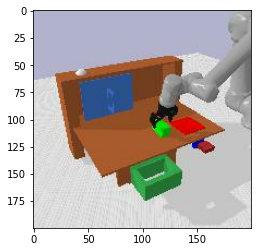

In [ ]:
try:
    data = list(np.load(path/f'{filename}.npz', allow_pickle=True)['data'])
except:
    data = []
    
while(1):
    batch = v_it.next()
    play_trajectory(batch['imgs'][0])
    val = input(f" {len(data)} Label: ")
    while val in ['r']:
            play_trajectory(images)
            val = input("Label: ")
            
    if val == 's':
        pass
    elif val == 'q':
        print(f'Saving')
        np.savez(path/filename, data=data, allow_objects=True)
        break
    else:
        if tagging:
            tag = input("Tag: ")
            data.append({'batch':batch, 'label':val, 'tag':tag_matching[int(tag)]})
        else:
            data.append({'batch':batch, 'label':val, 'tag': ""})
            
        np.savez(path/filename, data=data, allow_objects=True)

In [108]:
batch


{'obs': <tf.Tensor: shape=(1, 40, 18), dtype=float32, numpy=
 array([[[-8.56457874e-02,  2.30495021e-01,  1.04518041e-01,
           5.88905454e-01, -4.35020119e-01,  5.43073475e-01,
           9.22141612e-01,  1.56316787e-01,  4.32490200e-01,
          -1.00074121e-05,  9.59305311e-08, -8.24938695e-08,
          -6.14882529e-01,  7.88618743e-01,  7.50165805e-02,
          -1.30100757e-01,  2.99999993e-02,  0.00000000e+00],
         [-1.10718608e-01,  2.36108005e-01,  1.09141260e-01,
           5.85160375e-01, -4.50386077e-01,  6.03798509e-01,
           9.77231562e-01,  1.56316802e-01,  4.32490200e-01,
          -1.00034995e-05,  4.52937883e-08, -3.89498105e-08,
          -6.14882529e-01,  7.88618743e-01,  7.50165805e-02,
          -1.30100757e-01,  2.99999993e-02,  0.00000000e+00],
         [-1.33022696e-01,  2.43940353e-01,  1.12779357e-01,
           5.79050958e-01, -4.62944478e-01,  6.62515998e-01,
           9.95389879e-01,  1.56316802e-01,  4.32490200e-01,
          -1.00019524e

In [107]:
import tensorflow_hub as hub
embed = hub.KerasLayer(str(STORAGE_PATH)+'/saved_models/universal_sentence_encoder')

In [ ]:
save_path = str(path/'tf_records')+f"/{filename}.tfrecords"

In [119]:
save_path = str(path/'tf_records')+f"\\{filename}.tfrecords"
save_path

'C:\\Users\\Sholto Douglas\\Desktop\\robotics\\learning_from_play\\data\\pybullet\\UR5_slow_gripper_test\\tf_records\\tagged_labels.tfrecords'

In [121]:
from tqdm import tqdm
with tf.io.TFRecordWriter(save_path) as file_writer:
        for d in tqdm(data):
            trajectory = {k:v[0] for k,v in d['batch'].items() if k not in ['dataset_path', 'tstep_idxs']}
            trajectory['seq_lens'] = trajectory['obs'].shape[0]
            trajectory['masks'] = tf.ones([ trajectory['obs'].shape[0]])
            trajectory['goal_imgs'] = trajectory['imgs'][-1]
            trajectory['label'] = d['label']
            trajectory['label_embedding'] = np.squeeze(embed([d['label']])) # # 512
            trajectory['tag'] = d['tag']
            byte_stream = serialise_traj(trajectory)
            file_writer.write(byte_stream)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 15.21it/s]


In [10]:
record_paths = []
for p in [TRAIN_DATA_PATHS[0]]:
    record_paths += tf.io.gfile.glob(str(p/'tf_records/*.tfrecords'))
d = extract_tfrecords(record_paths)

TypeError: 'WindowsPath' object is not iterable

In [7]:
it = iter(d)


In [15]:
obs, acts, ags = [], [], []
for i in range(0,5000):
    d1 = it.next()
    obs.append(tf.io.parse_tensor(d1['obs'], tf.float32))
    acts.append(tf.io.parse_tensor(d1['acts'], tf.float32))
    ags.append(tf.io.parse_tensor(d1['achieved_goals'], tf.float32))

In [17]:
np.array(obs).shape

(5000, 18)

In [ ]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

def serialise(data):
    
    obs, acts, achieved_goals, joint_poses, target_poses, acts_quat, acts_rpy_rel, velocities, obs_quat, sequence_index, sequence_id, img , proprioception = data['obs'], data['acts'], data['achieved_goals'], data['joint_poses'], data['target_poses'], data['acts_quat'], data['acts_rpy_rel'], data['velocities'], data['obs_quat'], data['sequence_index'], data['sequence_id'], data['img'], data['proprioception']
    obs = Feature(bytes_list=BytesList(value=[obs.numpy(),]))
    acts = Feature(bytes_list=BytesList(value=[acts.numpy(),]))
    achieved_goals = Feature(bytes_list=BytesList(value=[achieved_goals.numpy(),])) 
    joint_poses = Feature(bytes_list=BytesList(value=[joint_poses.numpy(),])) 
    target_poses = Feature(bytes_list=BytesList(value=[target_poses.numpy(),]))
    acts_quat = Feature(bytes_list=BytesList(value=[acts_quat.numpy(),]))
    acts_rpy_rel = Feature(bytes_list=BytesList(value=[acts_rpy_rel.numpy(),])) 
    velocities = Feature(bytes_list=BytesList(value=[velocities.numpy(),])) 
    obs_quat = Feature(bytes_list=BytesList(value=[obs_quat.numpy(),]))
    proprioception = Feature(bytes_list=BytesList(value=[proprioception.numpy(),])) 
    sequence_index =  Feature(int64_list=Int64List(value=[sequence_index.numpy(),]))
    sequence_id = Feature(int64_list=Int64List(value=[sequence_id.numpy(),]))
    img = Feature(bytes_list=BytesList(value=[img.numpy(),]))
    # img is already serialised because we never decode it!
    
    features = Features(feature={
                'obs': obs,
                'acts': acts,
                'achieved_goals': achieved_goals,
                'joint_poses': joint_poses,
                'target_poses': target_poses,
                'acts_quat': acts_quat,
                'acts_rpy_rel': acts_rpy_rel,
                'velocities': velocities,
                'obs_quat': obs_quat,
                'proprioception': proprioception,
                'sequence_index': sequence_index,
                'sequence_id': sequence_id,
                'img': img,
                })
    
    example = Example(features=features)
    
    return example.SerializeToString()

In [ ]:
# Write the records to a file.
from tqdm import tqdm_notebook
counter = 0
i = 0
path = str(STORAGE_PATH/'unified/tf_records')+f"/{counter}.tfrecords"
path
it = iter(d)
with tf.io.TFRecordWriter(path) as file_writer:
      for data in tqdm_notebook(it):
          byte_stream = serialise(data)
          file_writer.write(byte_stream)
          i += 1
          if (i>0) and (i % 25000 == 0):
            counter += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':

753it [00:32, 46.41it/s]

In [ ]:
serialise(d1)

b'\n\xc1;\n:\n\x0cacts_rpy_rel\x12*\n(\n&\x08\x01\x12\x04\x12\x02\x08\x07"\x1c\xe4\xdd\x03\xbc,v,\xbdP\x05V\xbc\x97\xfb\x1e=\xc2\xd5\xd6\xbel\xfb\xce?\x00\x00\x00\x00\n4\n\nvelocities\x12&\n$\n"\x08\x01\x12\x04\x12\x02\x08\x06"\x18\x86m\xa6;\x87\xa0{\xba\x9cx\x82\xbb=\xa7\xeb\xbb\xa6\x0e\xcb\xbc\x96\xc1\xa6\xb9\n2\n\x04acts\x12*\n(\n&\x08\x01\x12\x04\x12\x02\x08\x07"\x1c\xf8\xae\x81\xbdb5\xc4=\xf5?\x7f>PH(=\xa1N\xd3\xbe\xf7\xfd\xce?\x00\x00\x00\x00\nL\n\x0eachieved_goals\x12:\n8\n6\x08\x01\x12\x04\x12\x02\x08\x0b",\x1eZ\xd3\xbd\xd7\xaeG=\x86}-\xb7l\xe1\xa7)7\xd3p\xa8\xeb!\x9d)\x00\x00\x80?\xb4\x7f\x08#\x00\x00\x00\x00h\xae\xd3<\x00\x00\x00\x00\n\x14\n\x0bsequence_id\x12\x05\x1a\x03\n\x01\x00\nf\n\x08obs_quat\x12Z\nX\nV\x08\x01\x12\x04\x12\x02\x08\x13"Lwfb\xbd<8\r>%P\x86>\xd4\xc6\x94:\xe1\xc8a;\x82W\x128\x92\xff\x7f?\xef\xa5\xcd\xb6\x1eZ\xd3\xbd\xd7\xaeG=\x86}-\xb7l\xe1\xa7)7\xd3p\xa8\xeb!\x9d)\x00\x00\x80?\xb4\x7f\x08#\x00\x00\x00\x00h\xae\xd3<\x00\x00\x00\x00\n6\n\x0ctarget_poses\x12&

In [ ]:
record_paths = tf.io.gfile.glob(str(STORAGE_PATH/'unified/tf_records/*.tfrecords'))
d2 = extract_tfrecords(record_paths)

In [ ]:
it = iter(d2)

In [ ]:
c= 0
for i in it:
  c += 1
  if c % 1000 == 0:
    print(c, i['sequence_id'].numpy(), i['sequence_index'].numpy())

# d1_copy = it.next()
# d1_copy

1000 0 999
2000 0 1999
3000 0 2999
4000 1 682
5000 1 1682
6000 1 2682
7000 1 3682
8000 1 4682
9000 1 5682
10000 10 804
11000 10 1804
12000 10 2804
13000 10 3804
14000 10 4804
15000 10 5804
16000 11 198
17000 11 1198
18000 11 2198
19000 11 3198
20000 11 4198
21000 11 5198
22000 12 528
23000 12 1528
24000 12 2528
25000 13 830
26000 13 1830
27000 14 168
28000 14 1168
29000 14 2168
30000 14 3168
31000 14 4168
32000 14 5168
33000 14 6168
34000 14 7168
35000 14 8168
36000 14 9168
37000 15 839
38000 15 1839
39000 15 2839
40000 15 3839
41000 15 4839
42000 15 5839
43000 15 6839
44000 15 7839
45000 15 8839
46000 15 9839
47000 15 10839
48000 15 11839
49000 15 12839
50000 15 13839
51000 15 14839
52000 15 15839
53000 15 16839
54000 16 658
55000 16 1658
56000 16 2658
57000 16 3658
58000 16 4658
59000 16 5658
60000 16 6658
61000 16 7658
62000 17 156
63000 18 629
64000 18 1629
65000 18 2629
66000 18 3629
67000 18 4629
68000 18 5629
69000 18 6629
70000 18 7629
71000 19 954
72000 2 831
73000 2 1831
7400

In [ ]:
for k,v in d1.items():
  print(d1_copy[k].numpy() == v.numpy())

False
False
False
False
False
False
False
False
False
True
False
True
False


In [ ]:
batch_size = 16
def load_tf_records(filenames, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    # check, does this ignore intra order or just inter order? Both are an issue!
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=60) # automatically interleaves reads from multiple files - keep it at 1 we need the order
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=600)
    dataset =   dataset.repeat()\
                .batch(batch_size, drop_remainder=True)\
                # .prefetch(dl.prefetch_size)
    return dataset



In [ ]:
data_paths = [str(STORAGE_PATH/'precompute')+f"/{x}.tfrecords" for x in range(0,13)]
d =load_tf_records(data_paths, ordered=False)#['/home/sholto/Desktop/AI/learning_from_play/data/UR5_high_transition/tf_records/21.tfrecords'], ordered=True) #record_paths
print(d)
d = iter(d)
x = d.next()

<BatchDataset shapes: {obs: <unknown>, acts: <unknown>, goals: <unknown>, seq_lens: (16,), masks: <unknown>, imgs: <unknown>, goal_imgs: <unknown>, proprioceptive_features: <unknown>}, types: {obs: tf.float32, acts: tf.float32, goals: tf.float32, seq_lens: tf.int32, masks: tf.float32, imgs: tf.uint8, goal_imgs: tf.uint8, proprioceptive_features: tf.float32}>


In [ ]:
t = time.time()
for i in range(0,10):
  # print(i)
  x = d.next()
print(time.time()-t)

1.0041556358337402


In [ ]:
dl = lfp.data.PlayDataloader(include_imgs = args.images, batch_size=batch_size,  window_size=args.window_size_max, min_window_size=args.window_size_min)
train_data = dl.extract(TRAIN_DATA_PATHS, from_tfrecords=args.from_tfrecords)
train_dataset = dl.load(train_data)
test_it = iter(train_dataset)

{   'acts': TensorSpec(shape=(16, 40, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(16, None), dtype=tf.int32, name=None),
    'goal_imgs': TensorSpec(shape=(16, 40, 200, 200, 3), dtype=tf.uint8, name=None),
    'goals': TensorSpec(shape=(16, 40, 11), dtype=tf.float32, name=None),
    'imgs': TensorSpec(shape=(16, 40, 200, 200, 3), dtype=tf.uint8, name=None),
    'masks': TensorSpec(shape=(16, 40), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(16, 40, 18), dtype=tf.float32, name=None),
    'proprioceptive_features': TensorSpec(shape=(16, 40, 7), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(16,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(16, None), dtype=tf.int32, name=None)}
4.210890531539917


In [ ]:
t = time.time()
for i in range(0,10):
  test_it.next()
print(time.time()-t)

0.0570371150970459


In [ ]:
for i in range(0, 100):
  example = t_it.next()

In [ ]:
# np.frombuffer(example['goal_imgs'].numpy().tobytes(), np.uint8)

In [ ]:
bstr = serialise(example)

In [ ]:
d = read_tfrecord(bstr)

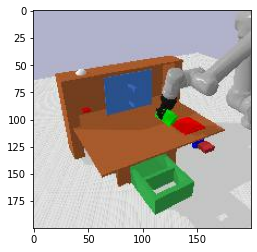

In [ ]:
import matplotlib.pyplot as plt 
plt.imshow(d['imgs'][0,15])

In [ ]:


def load_tf_records(filenames, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    # check, does this ignore intra order or just inter order? Both are an issue!
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE) # automatically interleaves reads from multiple files - keep it at 1 we need the order
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

d =load_dataset([record_paths], ordered=True)#['/home/sholto/Desktop/AI/learning_from_play/data/UR5_high_transition/tf_records/21.tfrecords'], ordered=True) #record_paths
print(d)
d = iter(d)

In [ ]:
for k,v in example.items():
  print(k, v.shape)

In [ ]:
d





with tf.io.TFRecordWriter(str(path/'tf_records/')+f"/{demo}.tfrecords") as file_writer:
            for data in it:
                byte_stream = serialise(data)
                file_writer.write(byte_stream)

In [ ]:
import subprocess
ll = args.train_datasets
print(ll)
files = []
for l in ll :
  files.append(tf.io.gfile.glob(f'gs://lfp_europe_west4_a/data/{l}/tf_records/*.tfrecords'))
  print(len(files))


def done(files):
  for l in files:
    if len(l) > 0:
      return False
  return True

counter = 0
while not done(files):
  for l in files:
    if len(l) > 0:
      r = l.pop()
      list_files = subprocess.run(["gsutil", "cp", r, f"gs://lfp_europe_west4_a/data/combined/tf_records/{counter}.tfrecords"])
      counter += 1
      print(r)

gs://lfp_europe_west4_a/data/UR5/tf_records/9.tfrecords
gs://lfp_europe_west4_a/data/UR5_slow_gripper/tf_records/9.tfrecords
gs://lfp_europe_west4_a/data/UR5_high_transition/tf_records/9.tfrecords
gs://lfp_europe_west4_a/data/UR5/tf_records/8.tfrecords
gs://lfp_europe_west4_a/data/UR5_slow_gripper/tf_records/8.tfrecords
gs://lfp_europe_west4_a/data/UR5_high_transition/tf_records/8.tfrecords
gs://lfp_europe_west4_a/data/UR5/tf_records/7.tfrecords
gs://lfp_europe_west4_a/data/UR5_slow_gripper/tf_records/7.tfrecords
gs://lfp_europe_west4_a/data/UR5_high_transition/tf_records/7.tfrecords
gs://lfp_europe_west4_a/data/UR5/tf_records/6.tfrecords
gs://lfp_europe_west4_a/data/UR5_slow_gripper/tf_records/6.tfrecords
gs://lfp_europe_west4_a/data/UR5_high_transition/tf_records/6.tfrecords
gs://lfp_europe_west4_a/data/UR5/tf_records/51.tfrecords
gs://lfp_europe_west4_a/data/UR5_slow_gripper/tf_records/5.tfrecords
gs://lfp_europe_west4_a/data/UR5_high_transition/tf_records/5.tfrecords
gs://lfp_europ